In [1]:
!pip install mxnet-cu112
!sudo apt install libnccl2

Keyring is skipped due to an exception: 'keyring.backends'
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libnccl2 is already the newest version (2.15.5-1+cuda11.8).
0 upgraded, 0 newly installed, 0 to remove and 168 not upgraded.
W: Target Packages (main/binary-amd64/Packages) is configured multiple times in /etc/apt/sources.list.d/google-chrome.list:3 and /etc/apt/sources.list.d/google.list:1
W: Target Packages (main/binary-all/Packages) is configured multiple times in /etc/apt/sources.list.d/google-chrome.list:3 and /etc/apt/sources.list.d/google.list:1


In [2]:
!pip install --upgrade gluoncv

Keyring is skipped due to an exception: 'keyring.backends'
Requirement already up-to-date: gluoncv in /home/irteam/anaconda3/lib/python3.7/site-packages (0.10.5.post0)


# 6. Dive Deep into Training SlowFast mdoels on Kinetcis400

This is a video action recognition tutorial using Gluon CV toolkit, a step-by-step example.
The readers should have basic knowledge of deep learning and should be familiar with Gluon API.
New users may first go through `A 60-minute Gluon Crash Course <http://gluon-crash-course.mxnet.io/>`_.
You can `Start Training Now`_ or `Dive into Deep`_.

## Start Training Now

<div class="alert alert-info"><h4>Note</h4><p>Feel free to skip the tutorial because the training script is self-complete and ready to launch.

    :download:`Download Full Python Script: train_recognizer.py<../../../scripts/action-recognition/train_recognizer.py>`

    For more training command options, please run ``python train_recognizer.py -h``
    Please checkout the `model_zoo <../model_zoo/index.html#action_recognition>`_ for training commands of reproducing the pretrained model.</p></div>


### Network Structure

First, let's import the necessary libraries into python.




In [4]:
!pip install mxnet

Keyring is skipped due to an exception: 'keyring.backends'


In [1]:
from __future__ import division

import argparse, time, logging, os, sys, math

import numpy as np
import mxnet as mx
import gluoncv as gcv
from mxnet import gluon, nd, init, context
from mxnet import autograd as ag
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

from gluoncv.data.transforms import video

from gluoncv.data import Kinetics400
from gluoncv.model_zoo import get_model
from gluoncv.utils import makedirs, LRSequential, LRScheduler, split_and_load, TrainingHistory

/home/irteam/anaconda3/lib/python3.7/site-packages/gluoncv/__init__.py:40: UserWarning: Both `mxnet==1.9.1` and `torch==1.7.1+cu110` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '


Here we pick a widely adopted model, ``SlowFast``, for the tutorial.
`SlowFast <https://arxiv.org/abs/1812.03982>`_ is a new 3D video
classification model, aiming for best trade-off between accuracy and efficiency.
It proposes two branches, fast branch and slow branch, to handle different aspects in a video.
Fast branch is to capture motion dynamics by using many but small video frames.
Slow branch is to capture fine apperance details by using few but large video frames.
Features from two branches are combined using lateral connections.



In [49]:
# number of GPUs to use
num_gpus = 2
ctx = [mx.gpu(i) for i in range(num_gpus)]

# Get the model slowfast_4x16_resnet50_kinetics400 with 400 output classes, without pre-trained weights
net = get_model(name='slowfast_4x16_resnet50_kinetics400', nclass=3)
net.collect_params().reset_ctx(ctx)
print(net)

SlowFast(
  (fast_conv1): Conv3D(3 -> 8, kernel_size=(5, 7, 7), stride=(1, 2, 2), padding=(2, 3, 3), bias=False)
  (fast_bn1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=8)
  (fast_relu): Activation(relu)
  (fast_maxpool): MaxPool3D(size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1), ceil_mode=False, global_pool=False, pool_type=max, layout=NCDHW)
  (fast_res2): HybridSequential(
    (0): Bottleneck(
      (conv1): Conv3D(8 -> 8, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
      (bn1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=8)
      (conv2): Conv3D(8 -> 8, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1), bias=False)
      (bn2): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=8)
      (conv3): Conv3D(8 -> 32, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
      (bn3): BatchNorm(axis=1,

### Data Augmentation and Data Loader

Data augmentation for video is different from image. For example, if you
want to randomly crop a video sequence, you need to make sure all the video
frames in this sequence undergo the same cropping process. We provide a
new set of transformation functions, working with multiple images.
Please checkout the `video.py <../../../gluoncv/data/transforms/video.py>`_ for more details.
Most video data augmentation strategies used here are introduced in [Wang15]_.



In [50]:
transform_train = transforms.Compose([
    # Fix the input video frames size as 256×340 and randomly sample the cropping width and height from
    # {256,224,192,168}. After that, resize the cropped regions to 224 × 224.
    video.VideoMultiScaleCrop(size=(224, 224), scale_ratios=[1.0, 0.875, 0.75, 0.66]),
    # Randomly flip the video frames horizontally
    video.VideoRandomHorizontalFlip(),
    # Transpose the video frames from height*width*num_channels to num_channels*height*width
    # and map values from [0, 255] to [0,1]
    video.VideoToTensor(),
    # Normalize the video frames with mean and standard deviation calculated across all images
    video.VideoNormalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

With the transform functions, we can define data loaders for our
training datasets.



In [51]:
# Batch Size for Each GP
per_device_batch_size = 3
# Number of data loader workers
num_workers = 0
# Calculate effective total batch size
batch_size = per_device_batch_size * num_gpus


# Set train=True for training the model.
# ``new_length`` indicates the number of frames we will cover.
# For SlowFast network, we evenly sample 32 frames for the fast branch and 4 frames for the slow branch.
# This leads to the actual input length of 36 video frames.
train_dataset = Kinetics400(train=True, new_length=64, slowfast=True, transform=transform_train, root='/home/irteam/god2000sus-dcloud-dir/swim_dataset/rawframes_train', setting='/home/irteam/god2000sus-dcloud-dir/swim_dataset/swim_train_list_rawframes.txt')
print('Load %d training samples.' % len(train_dataset))
train_data = gluon.data.DataLoader(train_dataset, batch_size=batch_size,
                                   shuffle=True, num_workers=num_workers)

Load 4 training samples.


### Optimizer, Loss and Metric



In [52]:
lr_decay = 0.1
warmup_epoch = 34
total_epoch = 196
num_batches = len(train_data)
lr_scheduler = LRSequential([
    LRScheduler('linear', base_lr=0.01, target_lr=0.1,
                nepochs=warmup_epoch, iters_per_epoch=num_batches),
    LRScheduler('cosine', base_lr=0.1, target_lr=0,
                nepochs=total_epoch - warmup_epoch,
                iters_per_epoch=num_batches,
                step_factor=lr_decay, power=2)
])

# Stochastic gradient descent
optimizer = 'sgd'
# Set parameters
optimizer_params = {'learning_rate': 0.01, 'wd': 0.0001, 'momentum': 0.9}
optimizer_params['lr_scheduler'] = lr_scheduler

# Define our trainer for net
trainer = gluon.Trainer(net.collect_params(), optimizer, optimizer_params)

In order to optimize our model, we need a loss function.
For classification tasks, we usually use softmax cross entropy as the
loss function.



In [53]:
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

For simplicity, we use accuracy as the metric to monitor our training
process. Besides, we record metric values, and will print them at the
end of training.



In [54]:
train_metric = mx.metric.Accuracy()
train_history = TrainingHistory(['training-acc'])

### Training

After all the preparations, we can finally start training!
Following is the script.

<div class="alert alert-info"><h4>Note</h4><p>In order to finish the tutorial quickly, we only train for 0 epoch on a tiny subset of Kinetics400,
  and 100 iterations per epoch. In your experiments, we recommend setting ``epochs=100`` for the full Kinetics400 dataset.</p></div>



[Epoch 0] train=0.000000 loss=2.429816 time: 1.491777
[Epoch 1] train=0.500000 loss=1.832961 time: 1.025352
[Epoch 2] train=0.500000 loss=2.019147 time: 1.124791
[Epoch 3] train=0.500000 loss=1.565845 time: 1.178331
[Epoch 4] train=1.000000 loss=1.179511 time: 1.089160
[Epoch 5] train=0.250000 loss=2.538189 time: 1.041796
[Epoch 6] train=1.000000 loss=0.901885 time: 1.121578
[Epoch 7] train=1.000000 loss=0.557250 time: 1.174857
[Epoch 8] train=0.500000 loss=1.295294 time: 1.168811
[Epoch 9] train=1.000000 loss=0.758719 time: 1.063847


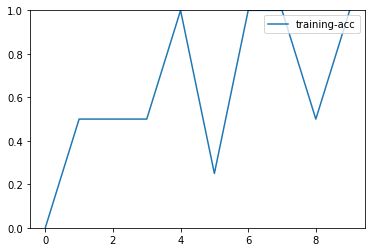

In [55]:
epochs = 10

for epoch in range(epochs):
    tic = time.time()
    train_metric.reset()
    train_loss = 0

    # Loop through each batch of training data
    for i, batch in enumerate(train_data):
        # Extract data and label
        data = split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
        label = split_and_load(batch[1], ctx_list=ctx, batch_axis=0, even_split=False)

        # AutoGrad
        with ag.record():
            output = []
            for _, X in enumerate(data):
                X = X.reshape((-1,) + X.shape[2:])
                pred = net(X)
                output.append(pred)
            loss = [loss_fn(yhat, y) for yhat, y in zip(output, label)]

        # Backpropagation
        for l in loss:
            l.backward()

        # Optimize
        trainer.step(batch_size)

        # Update metrics
        train_loss += sum([l.mean().asscalar() for l in loss])
        train_metric.update(label, output)

        if i == 100:
            break

    name, acc = train_metric.get()

    # Update history and print metrics
    train_history.update([acc])
    print('[Epoch %d] train=%f loss=%f time: %f' %
        (epoch, acc, train_loss / (i+1), time.time()-tic))

# We can plot the metric scores with:
train_history.plot()

In [56]:
# save model
file_name = "net.params"
net.save_parameters(file_name)

In [58]:
new_net = get_model(name='slowfast_4x16_resnet50_kinetics400', nclass=3)
new_net.load_parameters(file_name)

In [83]:
from gluoncv.utils.filesystem import try_import_decord
decord = try_import_decord()

vr = decord.VideoReader('/home/irteam/god2000sus-dcloud-dir/swim_dataset/val/drown/drowning.mp4')
fast_frame_id_list = range(0, 64, 2)
slow_frame_id_list = range(0, 64, 16)
frame_id_list = list(fast_frame_id_list) + list(slow_frame_id_list)
video_data = vr.get_batch(frame_id_list).asnumpy()
clip_input = [video_data[vid, :, :, :] for vid, _ in enumerate(frame_id_list)]

transform_fn = video.VideoGroupValTransform(size=224, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
clip_input = transform_fn(clip_input)
clip_input = np.stack(clip_input, axis=0)
clip_input = clip_input.reshape((-1,) + (36, 3, 224, 224))
clip_input = np.transpose(clip_input, (0, 2, 1, 3, 4))
print('Video data is downloaded and preprocessed.')

Video data is downloaded and preprocessed.


In [84]:
pred = new_net(nd.array(clip_input))

In [85]:
topK = 3
ind = nd.topk(pred, k=topK)[0].astype('int')
print('The input video clip is classified to be')
for i in range(topK):
    print('probability %.3f.'%
          (nd.softmax(pred)[0][ind[i]].asscalar()))

The input video clip is classified to be
probability 0.859.
probability 0.075.
probability 0.066.


Due to the tiny subset, the accuracy number is quite low.
You can `Start Training Now`_ on the full Kinetics400 dataset.

### References

.. [Wang15] Limin Wang, Yuanjun Xiong, Zhe Wang, and Yu Qiao. \
    "Towards Good Practices for Very Deep Two-Stream ConvNets." \
    arXiv preprint arXiv:1507.02159 (2015).

